## 3. Upper-Confidence-Bound Action Selection

A problem with the epoch-greedy action selection method is that it randomly picks an action without any preference for one or the other. For instance, the random action selected might be the one with the highest value and so we don't learn about the others. You can imagine that it would be preferably to pick from the non-greedy actions. We would also like to select an action based on its potential for being optimal by taking into account how close the estimates are to being maximal and the uncertainties in those estimates. Here we use:

$A_t = argmax_a \left[Q_t(a) + c\sqrt{\frac{\log t}{N_t(a)}}\right]$

log t is the natural logarithm of t

$N_t(a)$ is the number of times that action a has been selected prior to time t

c > 0 controls the degree of exploration. If c = 0, then the method is purely greedy.

You may view the square root term as our measure of uncertainty in the estimate of a's value. If $N_t(a) = 0$ then a is considered to be a maximizing action. Whenever a is selected, our uncertainty is reduced; since $N_t(a)$ is incremented and the value of the expression decreases. Similarly, after each selection, t is incremented and if some other action is selected, $N_t(a)$ is not incremented and so the uncertainty is increased. Since we used the natural logarithm, the increase gets smaller with time - as time goes by, we will have a lower selection frequency for actions with a lower value estimate or that have been selected more times. The quantity being maxed over can be seen as an upper bound on the possible true values of action a.

We now compare UCB ($c = 2$) and $\epsilon$-greedy ($\epsilon = 0.1$) action selection on the same 10-armed testbed.

In [1]:
from math import sqrt, log
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def epoch_greedy(Q, N):
    """
    Epoch-greedy action selection
    :param Q: the action-value estimates
    :param N: N[i] is the number of times action i has been executed
    """
    prob = np.random.rand(1)
    
    if prob > epsilon:
        # Greedy (exploit current knowledge)
        a = np.random.choice(np.flatnonzero(Q == Q.max()))
    else:
        # Explore (take random action)
        a = np.random.randint(0, len(N))
    
    return a

In [3]:
def ucb(Q, N, c, t):
    """
    Upper-confidence-bound action selection
    :param Q: the action-value estimates
    :param N: N[i] is the number of times action i has been executed    
    """
    not_executed = np.flatnonzero(N == 0)
    
    if len(not_executed) > 0:
        # Pick randomly from unselected actions
        a = np.random.choice(not_executed)
    else:        
        bounds = [Q[a] + c * sqrt(log(t) / N[a]) for a in range(len(N))]
        a = np.argmax(bounds)
        
    return a

In [4]:
def get_reward(true_values, a):
    """
    Returns the reward for selecting action a.
    Reward is selected around true_values[a] with unit variance (as in problem description)
    :param true_values: list of expected reward for each action
    :param a: index of action to return reward for
    """
    reward = np.random.normal(true_values[a], size=1)[0]
    return reward

In [5]:
def k_armed_bandit(k, epsilon, iterations, use_ucb, c):
    """
    Performs a single run of the k-armed bandit experiment
    :param k: the number of arms
    :param epsilon: Value of epsilon for epoch-greedy action selection
    :param iterations: number of steps in a single run
    :param use_ucb: if true, use upper-confidence-bound action selection. Otherwise, use epoch-greedy
    :param c: the value of constant c for ucb
    """
    # Randomly assign true values of reward for each action with mean 0 and variance 1
    true_values = np.random.normal(size=k)
    
    # Estimates of action values
    Q = np.zeros(k)

    # N[i] is the no. of times action i has been taken
    N = np.zeros(k)
    
    # Store the rewards received for this experiment
    rewards = []
    
    # Track how often the optimal action was selected
    optimal = []
    
    for i in range(1, iterations + 1):
        if use_ucb:
            a = ucb(Q, N, c, i)
        else:
            a = epoch_greedy(Q, N)
            
        reward = get_reward(true_values, a)        
        
        # Update statistics for executed action
        N[a] += 1
        Q[a] += (1.0 / N[a]) * (reward - Q[a])
        
        rewards.append(reward)
        optimal.append(1 if a == true_values.argmax() else 0)
    
    return rewards, optimal

In [6]:
def experiment(k, epsilon, iters, epochs, use_ucb=False, c=2):
    """
    Runs the k-armed bandit experiment
    :param k: the number of arms
    :param epsilon: the value of epsilon for epoch-greedy action selection
    :param iters: the number of steps in a single run
    :param epochs: the number of runs to execute
    :param use_ucb: if true, use upper-confidence-bound action selection. Otherwise, use epoch-greedy
    :param c: the value of constant c for ucb
    """
    rewards = []
    optimal = []
    
    for i in range(epochs):
        r, o = k_armed_bandit(k, epsilon, iters, use_ucb, c)
        rewards.append(r)
        optimal.append(o)
        
    if use_ucb:
        print('Experiment with upper-confidence bound completed.')
    else:
        print('Experiment with epoch-greedy completed.')
    
    # Compute the mean reward for each iteration
    r_means = np.mean(rewards, axis=0)
    o_means = np.mean(optimal, axis=0)
    
    return r_means, o_means

In [7]:
k = 10
epsilon = 0.1
c = 2
iters = 1000
runs = 2000

In [8]:
r_exp1, o_exp1 = experiment(k, epsilon, iters, runs)

Experiment with epoch-greedy completed.


In [9]:
r_exp2, o_exp2 = experiment(k, epsilon, iters, runs, use_ucb=True, c=c)

Experiment with upper-confidence bound completed.


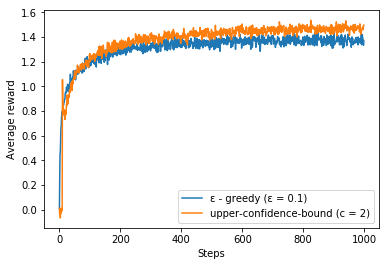

In [12]:
x = range(iters)
plt.plot(x, r_exp1, label='\u03b5 - greedy (\u03b5 = 0.1)')
plt.plot(x, r_exp2, label='upper-confidence-bound (c = 2)')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()
plt.show()

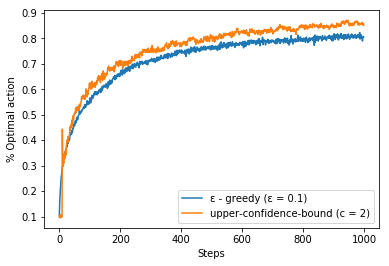

In [13]:
plt.plot(x, o_exp1, label='\u03b5 - greedy (\u03b5 = 0.1)')
plt.plot(x, o_exp2, label='upper-confidence-bound (c = 2)')
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()
plt.show()

As the results show, UCB outperforms the epoch-greedy method. After the first 10 steps, UCB has tried all of the 10 possible actions, whereas we cannot always make such a claim about the epoch-greedy action selection method.

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.